# Data Gathering and Processing


In [67]:
import pandas as pd
import csv
import requests
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

owner = "tmux"
repo = "tmux"
branch = "master"
days = 1826  # 5 years
since = (datetime.now() - timedelta(days=days)).isoformat()

### Fetch commit history from tmux GitHub repo


In [ ]:
base_url = f"https://api.github.com/repos/{owner}/{repo}/commits"
params = {"sha": "master", "since": since, "per_page": 100}


def fetch_commit_history(url, params):
    commit_history = []
    while url:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            commits = response.json()
            for commit in commits:
                commit_hash = commit["sha"]
                author_name = commit["commit"]["author"]["name"]
                commit_date = commit["commit"]["author"]["date"]
                commit_message = commit["commit"]["message"]
                commit_url = commit["html_url"]
                commit_history.append(
                    {
                        "date": commit_date,
                        "hash": commit_hash,
                        "message": commit_message,
                        "author_name": author_name,
                        "url": commit_url,
                    }
                )
            # Pagination
            if "next" in response.links:
                url = response.links["next"]["url"]
                params = {}  # Clear params since URL will contain them
            else:
                url = None
        else:
            print("Failed to fetch commits. Status Code:", response.status_code)
            break
    return commit_history


print(
    f"fetching commits since {since} from {owner}/{repo} on branch {branch}...")
commit_history = fetch_commit_history(base_url, params)
print(f"successfully fetched {len(commit_history)} commits")

with open("commit_history.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(
        file,
        fieldnames=[
            "date",
            "hash",
            "message",
            "author_name",
            "url",
        ],
    )
    writer.writeheader()
    writer.writerows(commit_history)

print(
    f"Successfully written {len(commit_history)} commits to commit_history.csv")

### Fetch release history from GitHub repo


In [18]:
url = f"https://api.github.com/repos/{owner}/{repo}/releases"

# Fetch all releases
releases = []
while url:
    response = requests.get(url)
    if response.status_code == 200:
        releases.extend(response.json())
        url = response.links.get("next", {}).get("url", None)
    else:
        print(f"Failed to fetch releases: {response.status_code}")
        break

# Write to CSV
with open("release_history.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Release Name", "Tag Name", "Created At", "Published At"])
    for release in releases:
        writer.writerow(
            [
                release["name"],
                release["tag_name"],
                release["created_at"],
                release["published_at"],
            ]
        )

print(f"Successfully written {len(releases)} releases to release_history.csv")

Successfully written 35 releases to release_history.csv


### Fetch issues from GitHub repo


In [43]:
params = {"state": "closed", "since": {since}, "per_page": 100}

issues_history = []

url = f"https://api.github.com/repos/{owner}/{repo}/issues"

while url:
    response = requests.get(url, params=params)
    if response.status_code == 200:
        issues = response.json()
        for issue in issues:
            if "number" in issue and "closed_at" in issue:
                issues_history.append(
                    {"Issue Number": issue["number"], "Closed At": issue["closed_at"]}
                )
        url = response.links["next"]["url"] if "next" in response.links else None
    else:
        print("Failed to fetch issues. Status Code:", response.status_code)
        break

with open("issue_history.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Issue Number", "Closed At"])
    for issue in issues_history:
        writer.writerow([issue["Issue Number"], issue["Closed At"]])

print(f"Successfully written {len(issues_history )} issues to issue_history.csv")

Successfully written 3786 issues to issue_history.csv


### Process commit history to match with issues


In [49]:
commit_history = pd.read_csv("commit_history.csv")
issues_history = pd.read_csv("issue_history.csv")


def extract_issue_number(message):
    pattern = r"GitHub issue (\d+)"
    match = re.search(pattern, message)
    return int(match.group(1)) if match else None


commit_history["Linked Issue"] = commit_history["message"].apply(extract_issue_number)
commit_history = commit_history.merge(
    issues_history, left_on="Linked Issue", right_on="Issue Number", how="inner"
)
commit_history.loc[commit_history["Closed At"].notnull(), "date"] = commit_history[
    "Closed At"
]
commit_history["Is Linked to Issue"] = commit_history["Linked Issue"].notnull()

# Save the updated commit history
commit_history.to_csv("commit_history_linked_with_issues.csv", index=False)
print("Successfully written commit_history_linked_with_issues.csv")

Successfully written commit_history_linked_with_issues.csv


### Compute time from release-ready to actual release: manual vs CD


In [72]:
def find_next_release(commit_date, release_dates):
    future_releases = release_dates[release_dates > commit_date]
    if not future_releases.empty:
        return future_releases.iloc[0]
    return None


def find_next_merge(commit_date, merge_dates):
    future_merges = merge_dates[merge_dates > commit_date]
    if not future_merges.empty:
        return future_merges.iloc[0]
    return None


release_history = pd.read_csv("release_history.csv")
release_history["Published At"] = pd.to_datetime(release_history["Published At"])
release_history = release_history.sort_values(by="Published At")

commit_history = pd.read_csv("commit_history_linked_with_issues.csv")
commit_history["date"] = pd.to_datetime(commit_history["date"])

# Identifying merge commits
merge_commits = commit_history[
    commit_history["message"].str.contains(
        "Merge branch 'obsd-master'", case=False, na=False
    )
]
merge_commits = merge_commits.sort_values(by="date")

commit_history = commit_history[commit_history["Is Linked to Issue"] == True]
commit_history["Closed At"] = pd.to_datetime(commit_history["Closed At"])
commit_history = commit_history.sort_values(by="Closed At")
commit_history["Next Release Time"] = commit_history["Closed At"].apply(
    lambda x: find_next_release(x, release_history["Published At"])
)
commit_history["Time to Next Release (Days)"] = (
    commit_history["Next Release Time"] - commit_history["Closed At"]
).dt.total_seconds() / (60 * 60 * 24)
commit_history["Next Merge Time"] = commit_history["Closed At"].apply(
    lambda x: find_next_merge(x, merge_commits["date"])
)
commit_history["Time to Next Merge (Days)"] = (
    commit_history["Next Merge Time"] - commit_history["Closed At"]
).dt.total_seconds() / (60 * 60 * 24)

commit_history = commit_history[
    (commit_history["Time to Next Release (Days)"].notnull())
    & (commit_history["Time to Next Merge (Days)"].notnull())
]

commit_history.rename(
    columns={
        "Time to Next Release (Days)": "Manual Release Delay (Days)",
        "Time to Next Merge (Days)": "CD Release Delay (Days)",
    },
    inplace=True,
)

commit_history.to_csv("processed_commit_history.csv", index=False)
print("Successfully written processed_commit_history.csv")

Successfully written processed_commit_history.csv


# Data Analysis


In [ ]:
data = pd.read_csv("processed_commit_history.csv")

### Time series of release delays


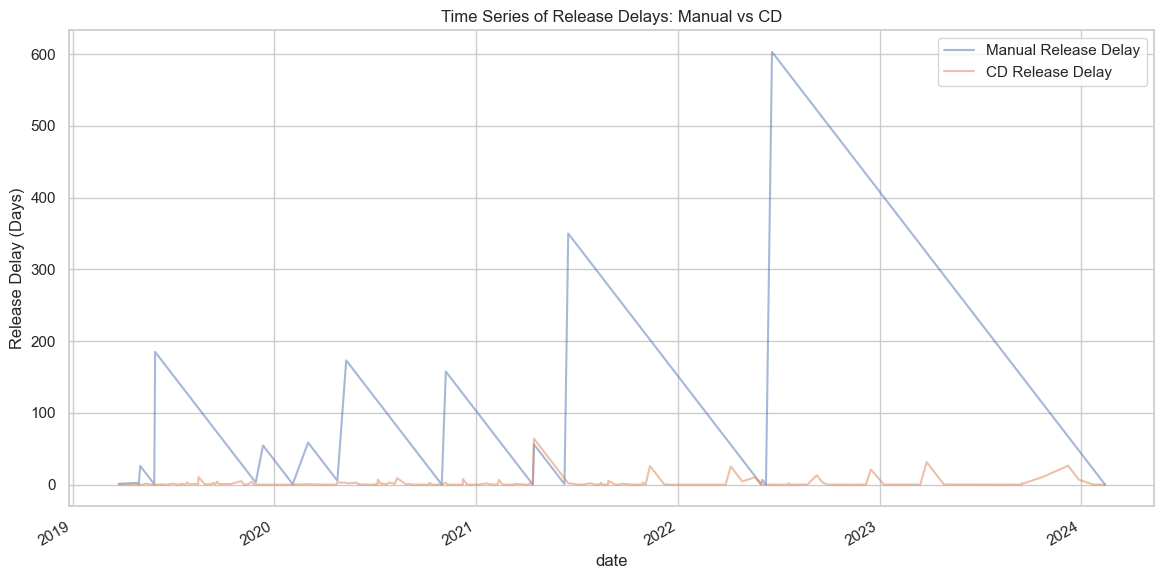

In [83]:
data["date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)

plt.figure(figsize=(14, 7))
data["Manual Release Delay (Days)"].plot(label="Manual Release Delay", alpha=0.5)
data["CD Release Delay (Days)"].plot(label="CD Release Delay", alpha=0.5)
plt.ylabel("Release Delay (Days)")
plt.title("Time Series of Release Delays: Manual vs CD")
plt.legend()
plt.savefig("time_series.png", bbox_inches="tight", dpi=500)
plt.show()

The time series plot above illustrates the release delays for both manual and Continuous Delivery (CD) processes over the past five years. Here are some observations and comments based on the plot:

- Trend Consistency: The CD release delay consistently shows lower values over time compared to the manual release delay, reinforcing the notion that CD significantly reduces the time it takes to release changes.
- Variability: The manual release delay exhibits higher variability, with several peaks indicating periods of particularly long delays. In contrast, the CD process maintains a much steadier and lower range of values, suggesting a more predictable and efficient release process.

This visual representation supports the hypothesis that Continuous Delivery leads to shorter release delays.


In [76]:
relevant_data = data[["Manual Release Delay (Days)", "CD Release Delay (Days)"]]

### Summary statistics


In [82]:
mean_manual_delay = relevant_data["Manual Release Delay (Days)"].mean()
mean_cd_delay = relevant_data["CD Release Delay (Days)"].mean()

percentage_reduction = ((mean_manual_delay - mean_cd_delay) / mean_manual_delay) * 100

mean_manual_delay, mean_cd_delay, percentage_reduction

(139.5552371040291, 6.050035948416117, 95.66477326543739)

In [79]:
summary_statistics = relevant_data.describe()
summary_statistics

,Manual Release Delay (Days),CD Release Delay (Days)
count,387.000000,387.000000
mean,139.555237,6.050036
std,142.494818,14.626607
min,0.036690,0.005613
25%,34.922882,0.055353
50%,98.849653,0.098345
75%,180.989502,2.174132
max,603.098947,64.062153


The summary statistics shows that there’s a substantial difference between the manual and CD release delays, with the CD process showing a significantly lower mean and median delay. This initial analysis supports the hypothesis that implementing Continuous Delivery (CD) in the tmux project can significantly reduce the release delay.


### Release delay distribution


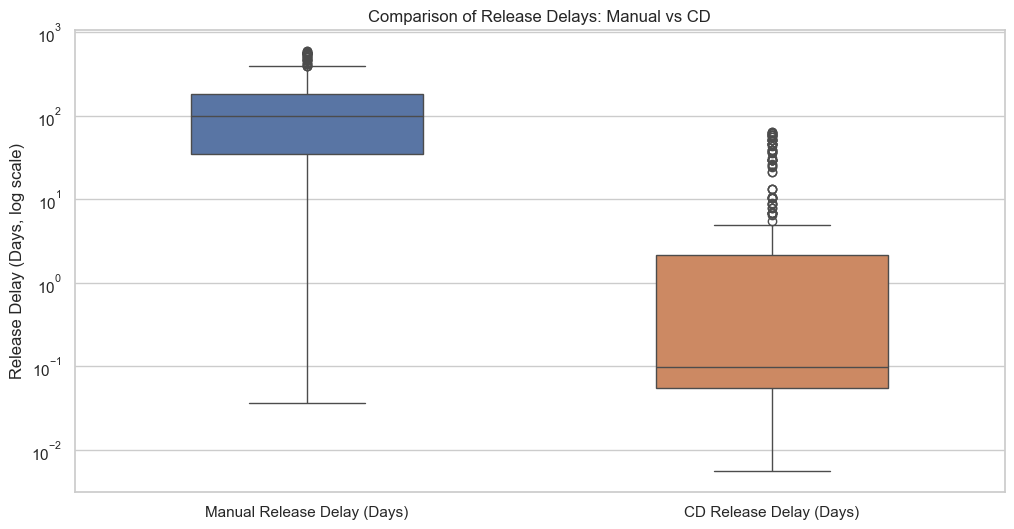

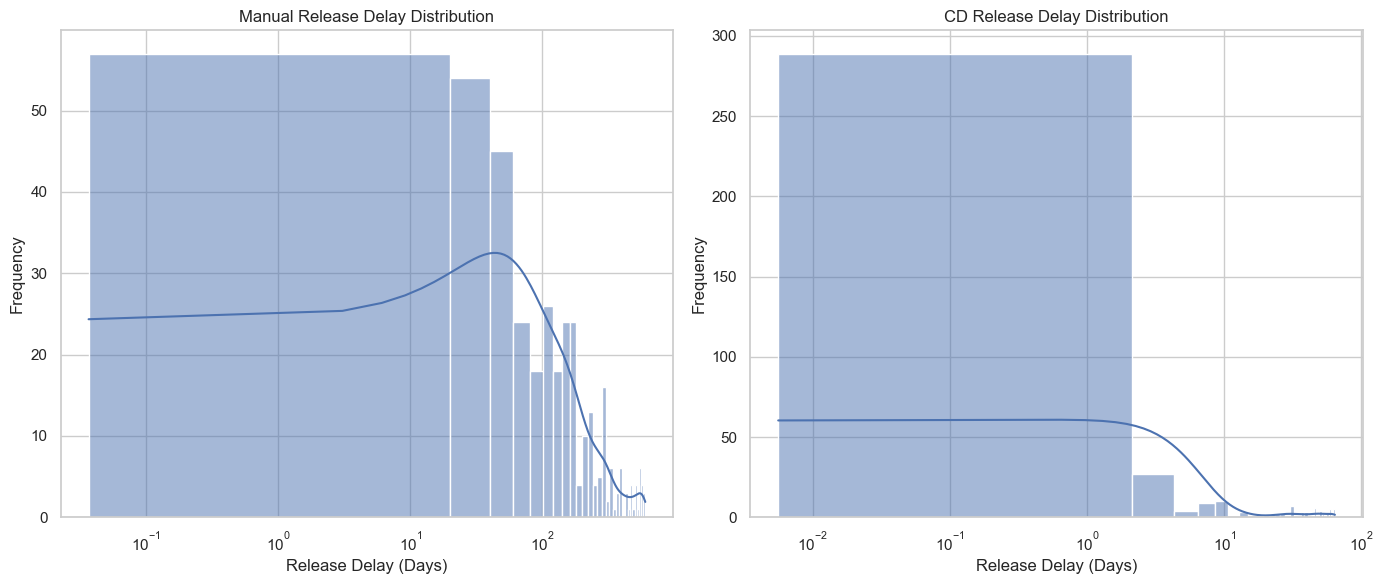

In [78]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting box plots to compare the distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=relevant_data, width=0.5)
plt.yscale("log")  # Using log scale due to wide range of values
plt.title("Comparison of Release Delays: Manual vs CD")
plt.ylabel("Release Delay (Days, log scale)")
plt.savefig("box_plot.png", bbox_inches="tight", dpi=500)
plt.show()

# Plotting histograms for a detailed distribution view
plt.figure(figsize=(14, 6))

# Manual Release Delay distribution
plt.subplot(1, 2, 1)
sns.histplot(data["Manual Release Delay (Days)"], bins=30, kde=True)
plt.title("Manual Release Delay Distribution")
plt.xlabel("Release Delay (Days)")
plt.ylabel("Frequency")
plt.xscale("log")

# CD Release Delay distribution
plt.subplot(1, 2, 2)
sns.histplot(data["CD Release Delay (Days)"], bins=30, kde=True)
plt.title("CD Release Delay Distribution")
plt.xlabel("Release Delay (Days)")
plt.ylabel("Frequency")
plt.xscale("log")

plt.tight_layout()
plt.savefig("histogram.png", bbox_inches="tight", dpi=500)
plt.show()

The visualizations for release delay provide a clearer picture of the release delays for the manual and CD processes:

- Box Plot: The comparison between manual and CD release delays shows a clear contrast. The CD process has a much tighter distribution of values, indicating a consistent and significantly lower delay. The log scale highlights the substantial difference in scale between the two processes.

- Histograms: Looking at the histograms, the release delay distribution for the manual process is much broader, indicating a wide variability in release times. The CD process, on the other hand, shows a very steep distribution centered around lower values, which indicates the efficiency of CD in reducing release delays.

These visual insights strongly support the hypothesis that implementing Continuous Delivery significantly reduces the release delay in the tmux project.


### Hypothesis testing

Given the non-normal distribution of the data, as suggested by the wide range and variability in delays, a non-parametric test such as the Wilcoxon signed-rank test would be appropriate. This test does not assume normal distribution and is used to compare two related samples.


In [81]:
from scipy.stats import wilcoxon

test_statistic, p_value = wilcoxon(
    data["Manual Release Delay (Days)"], data["CD Release Delay (Days)"]
)
test_statistic, p_value

(2583.0, 9.382536330259238e-57)

The p-value is significantly lower than the typical alpha level of 0.05, indicating that the difference in release delays between manual and CD processes is statistically significant.

This confirms the hypothesis that implementing Continuous Delivery (CD) in the tmux project significantly reduces the release delay when compared to the traditional manual release process.


### Conclusions

Continuous Delivery (CD) can significantly reduce the release delay in the tmux project compared to the manual release process. This is supported by summary statistics, visualizations, and hypothesis testing.

The average release delay is reduced from approximately 139.56 days in the manual process to about 6.05 days with the implementation of Continuous Delivery (CD), resulting in a reduction of approximately 95.66%.
